In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train[:8000].astype("float32")/255.0
y_train = y_train[:8000].ravel()
x_test  = x_test[:2000].astype("float32")/255.0
y_test  = y_test[:2000].ravel()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


In [3]:
base = tf.keras.applications.MobileNetV2(input_shape=(32,32,3), include_top=False, weights=None, alpha=0.5)
encoder_contrastive = models.Model(base.input, layers.GlobalAveragePooling2D()(base.output), name="encoder_contrastive")


In [4]:
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

projection_head = models.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(64)
], name="projection_head")

def nt_xent(z_i, z_j, temperature=0.5):
    z_i = tf.math.l2_normalize(z_i, axis=1)
    z_j = tf.math.l2_normalize(z_j, axis=1)
    logits = tf.matmul(z_i, z_j, transpose_b=True) / temperature
    labels = tf.range(tf.shape(logits)[0])
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True))


In [5]:
BATCH, EPOCHS, STEPS = 256, 3, 100
ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(20000).batch(BATCH, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
opt = tf.keras.optimizers.Adam(1e-3)

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        x_i, x_j = augment(x, training=True), augment(x, training=True)
        h_i, h_j = encoder_contrastive(x_i, training=True), encoder_contrastive(x_j, training=True)
        z_i, z_j = projection_head(h_i, training=True), projection_head(h_j, training=True)
        loss = nt_xent(z_i, z_j, 0.5)
    vars_ = encoder_contrastive.trainable_variables + projection_head.trainable_variables
    grads = tape.gradient(loss, vars_)
    opt.apply_gradients(zip(grads, vars_))
    return loss

for e in range(EPOCHS):
    m = tf.keras.metrics.Mean()
    for step, xb in enumerate(ds):
        if step >= STEPS: break
        m.update_state(train_step(xb))
    print(f"Contrastive Epoch {e+1}: loss={m.result().numpy():.4f}")


Contrastive Epoch 1: loss=5.3556
Contrastive Epoch 2: loss=4.8969
Contrastive Epoch 3: loss=4.4589


In [6]:
rep_contrastive_train = encoder_contrastive.predict(x_train, verbose=0)
rep_contrastive_test  = encoder_contrastive.predict(x_test,  verbose=0)
print(rep_contrastive_train.shape, rep_contrastive_test.shape)


(8000, 1280) (2000, 1280)


In [7]:
latent_dim = 64
encoder_ae = models.Sequential([
    layers.Input(shape=(32,32,3)),
    layers.Conv2D(32, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
    layers.Flatten(),
    layers.Dense(latent_dim)
], name="ae_encoder")

decoder_ae = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(8*8*64, activation="relu"),
    layers.Reshape((8,8,64)),
    layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2D(3, 3, padding="same", activation="sigmoid")
], name="ae_decoder")

inp = layers.Input(shape=(32,32,3))
out = decoder_ae(encoder_ae(inp))
autoencoder = models.Model(inp, out)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(x_train, x_train, epochs=5, batch_size=256, validation_data=(x_test, x_test), verbose=1)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - loss: 0.0629 - val_loss: 0.0430
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0375 - val_loss: 0.0265
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0242 - val_loss: 0.0216
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0206 - val_loss: 0.0189
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0183 - val_loss: 0.0174


In [8]:
rep_ae_train = encoder_ae.predict(x_train, verbose=0)
rep_ae_test  = encoder_ae.predict(x_test,  verbose=0)
print(rep_ae_train.shape, rep_ae_test.shape)


(8000, 64) (2000, 64)


Linear eval — Contrastive reps: 0.108
Linear eval — Autoencoder reps: 0.3315


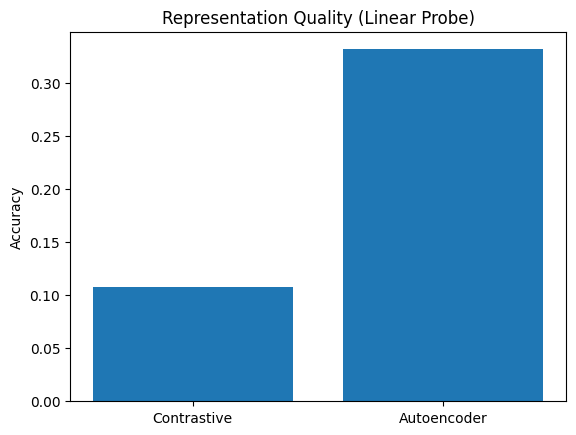

In [9]:
clf_c = LogisticRegression(max_iter=2000).fit(rep_contrastive_train, y_train)
acc_c  = accuracy_score(y_test, clf_c.predict(rep_contrastive_test))

clf_a = LogisticRegression(max_iter=2000).fit(rep_ae_train, y_train)
acc_a  = accuracy_score(y_test, clf_a.predict(rep_ae_test))

print("Linear eval — Contrastive reps:", acc_c)
print("Linear eval — Autoencoder reps:", acc_a)

plt.bar(["Contrastive","Autoencoder"], [acc_c, acc_a])
plt.ylabel("Accuracy")
plt.title("Representation Quality (Linear Probe)")
plt.show()
